In [1]:
import importlib
import classesV3.ProCtrlDataLoader as DataLoader
import pandas as pd

In [2]:
importlib.reload(DataLoader)
start_path = './DATA/jan24_data/'
loadTest = DataLoader.ProCtrlDataLoader(start_path, ['bio','arb','control'],[], [])
loadTest.loaddata()
loadTest.printDict()

'bio'
sub-bi08 sub-bi06 sub-bi07 sub-bi09 sub-bi13 sub-bi12 sub-bi05 sub-bi02 sub-bi03 sub-bi04 sub-bi10 sub-bi11
'arb'
sub-ar10 sub-ar11 sub-ar06 sub-ar08 sub-ar09 sub-ar07 sub-ar13 sub-ar14 sub-ar12
'control'
sub-co05 sub-co04 sub-co03 sub-co10 sub-co11 sub-co08 sub-co01 sub-co07 sub-co09


In [10]:
a = [1,2,3]
b = [3,4,5]
c = [5,6,7]
d = [a,b,c]

print(d)
print(*d)

e = []

for list in [*d]:
    e = [*e, *list]

print(e)

# For you to see how this can make weird stuff happen:
f = []
for list in [*d]:
    f = [f, *list]

print(f)

[[1, 2, 3], [3, 4, 5], [5, 6, 7]]
[1, 2, 3] [3, 4, 5] [5, 6, 7]
[1, 2, 3, 3, 4, 5, 5, 6, 7]
[[[[], 1, 2, 3], 3, 4, 5], 5, 6, 7]


### Basic Data Display Methods

In [3]:
# Displays basic class_means_file df (raw EMG data, accuracy values)

test_ag_file = loadTest.training_groups['arb']['sub-ar07']['sess2']['post_trained']


test_ag_file.armgame_df


cm_df = test_ag_file.raw_cm_features

hi = test_ag_file.feature_df.loc[(0,1):(0,8),1]

test_ag_file.diff_from_f1(18)
test_ag_file.f1_distances

classAccData = loadTest.aggregate_sess_x_group_df(['bio','arb', 'control'])

bio
arb
control


In [ ]:
loadTest.print_acc_lines(['arb','bio'])

In [4]:
test_ag_file.armgame_df

,entryID,entryType,outerZoneRadius,class,emgChan1,emgChan2,emgChan3,emgChan4,emgChan5,emgChan6,emgChan7,emgChan8,goal,total_acc
0,0,1,0.19941,0,560,394,484,366,181,165,126,188,0,0
1,1,1,0.19941,17,656,440,527,425,186,166,132,177,0,0
2,2,1,0.19941,18,690,425,520,540,184,161,138,179,0,0
3,3,1,0.19941,18,703,393,495,539,185,160,138,171,0,0
4,4,1,0.19941,18,674,365,419,512,163,163,140,162,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2926,0,0.19941,0,114,134,127,120,124,123,127,117,0,0
2927,2927,0,0.19941,0,119,130,124,126,129,116,130,110,0,0
2928,2928,0,0.19941,0,127,117,119,130,128,115,130,105,0,0
2929,2929,0,0.19941,0,121,116,113,140,133,116,130,112,0,0


In [5]:
test_ag_file.diff_from_f1(0)
test_ag_file

In [64]:
def classify_raw_emg_over_f1(ag_object):
    dist_to_rest = ag_object.diff_from_f1(0)
    dist_to_open = ag_object.diff_from_f1(17)
    dist_to_close = ag_object.diff_from_f1(18)

    f1_distance_avgs = pd.DataFrame(columns = ['0','17','18','f1_dist_class','coapt_class', 'goal_output'])

    for gesture in ag_object.chunk_bounds:
        if gesture == 'pinch' or gesture == 'tripod':
            continue
        for bounds in ag_object.chunk_bounds[gesture]:
        
            temp_chunk_dist_avgs = pd.DataFrame(columns = ['0','17','18'])
            
            start = bounds[0]
            end = bounds[1]

            curr_df = ag_object.armgame_df
            
            temp_chunk_dist_avgs['0'] = abs(dist_to_rest.iloc[start:end].sum(axis=1) / 8)
            temp_chunk_dist_avgs['17'] = abs(dist_to_open.iloc[start:end].sum(axis=1) / 8)
            temp_chunk_dist_avgs['18'] = abs(dist_to_close.iloc[start:end].sum(axis=1) / 8)
            

            temp_chunk_dist_avgs['f1_dist_class'] = temp_chunk_dist_avgs.idxmin(axis='columns')

            temp_chunk_dist_avgs['coapt_class'] = curr_df['class'].iloc[start:end]

            temp_chunk_dist_avgs['goal_output'] = curr_df['goal'].iloc[start:end]
            # temp_chunk_dist_avgs = temp_chunk_dist_avgs.reset_index(drop = True)        

            # print(temp_chunk_dist_avgs.to_string())

            f1_distance_avgs = f1_distance_avgs.append(temp_chunk_dist_avgs)

    return f1_distance_avgs


f1_classifier = classify_raw_emg_over_f1(test_ag_file)

def get_accuracy_for_f1_classifier(f1_classifier_df):
    temp_df = pd.DataFrame(columns=['f1_class_acc','coapt_class_acc', 'f1_coapt_agreement'])

    temp_df['f1_class_acc'] = pd.to_numeric(f1_classifier_df['f1_dist_class']) & f1_classifier_df['goal_output']

    temp_df['coapt_class_acc'] = f1_classifier_df['coapt_class'] & pd.to_numeric(f1_classifier_df['goal_output'])

    temp_df['f1_coapt_agreement'] = pd.to_numeric(f1_classifier_df['f1_dist_class']) & f1_classifier_df['coapt_class']

    f1_class_acc = sum(temp_df['f1_class_acc']) / len(temp_df)
    coapt_class_acc = sum(temp_df['coapt_class_acc']) / len(temp_df)
    f1_coapt_agreement = sum(temp_df['f1_coapt_agreement']) / len(temp_df)

    temp_accuracies = [f1_class_acc,coapt_class_acc,f1_coapt_agreement]

    return temp_df, temp_accuracies

f1_agreement_df, agreement_acc_values = get_accuracy_for_f1_classifier(f1_classifier)
print(f1_agreement_df)
print(agreement_acc_values)

def dataset_f1_agreement(DataSet):

    temp_df = pd.DataFrame(columns=['group','subj','sess','f1_class_acc','coapt_class_acc','f1_coapt_agreement'])

    for group in DataSet.training_groups:
        for participant in DataSet.training_groups[group].keys():
            if 'bi05' in participant:
                continue
            for sess in DataSet.training_groups[group][participant].keys():
                temp_acc_values = [0,0,0]
                for prepost in ['pre_trained','post_trained']:
                    print(group,participant,sess,prepost)
                    if prepost not in DataSet.training_groups[group][participant][sess].keys():
                        continue
                    temp_ag_object = DataSet.training_groups[group][participant][sess][prepost]
                    temp_f1_classifier = classify_raw_emg_over_f1(temp_ag_object)
                    junk_df,hold_acc_values = get_accuracy_for_f1_classifier(temp_f1_classifier) 

                    temp_acc_values = [a + b for a, b in zip(temp_acc_values,hold_acc_values)]  
                
                temp_acc_values = [x / 2 for x in temp_acc_values]
                new_row = [group,participant,sess,*temp_acc_values]
                temp_df.loc[len(temp_df)] = new_row


    return temp_df

dataset_f1_agreement_df = dataset_f1_agreement(loadTest)


      f1_class_acc  coapt_class_acc  f1_coapt_agreement
61           False            False                True
62           False            False                True
63           False            False                True
64           False            False                True
65           False            False                True
...            ...              ...                 ...
2763          True             True                True
2764          True             True                True
2765          True             True                True
2766          True             True                True
2767          True             True                True

[2702 rows x 3 columns]
[0.6739452257586973, 0.6384159881569208, 0.7446336047372317]
bio sub-bi08 sess6 pre_trained
bio sub-bi08 sess6 post_trained
bio sub-bi08 sess3 pre_trained
bio sub-bi08 sess3 post_trained
bio sub-bi08 sess4 pre_trained
bio sub-bi08 sess4 post_trained
bio sub-bi08 sess5 pre_trained
bio sub-bi08 sess5 pos

In [72]:
dataset_f1_agreement_df = dataset_f1_agreement_df.sort_values(by=['group','subj','sess'])


data_set_f1_class_acc = sum(dataset_f1_agreement_df['f1_class_acc']) / len(dataset_f1_agreement_df)
data_set_coapt_class_acc = sum(dataset_f1_agreement_df['coapt_class_acc']) / len(dataset_f1_agreement_df)
data_set_f1_coapt_agreement = sum(dataset_f1_agreement_df['f1_coapt_agreement']) / len(dataset_f1_agreement_df)



dataset_f1_agreement_df.loc[len(dataset_f1_agreement_df)] = ['all_group','all_subj','all_sess',data_set_f1_class_acc,data_set_coapt_class_acc,data_set_f1_coapt_agreement]

       group      subj   sess  f1_class_acc  coapt_class_acc  f1_coapt_agreement
69       arb  sub-ar06  sess2      0.637561         0.635755            0.668615
66       arb  sub-ar06  sess3      0.331669         0.321125            0.325194
67       arb  sub-ar06  sess4      0.331852         0.327407            0.334630
68       arb  sub-ar06  sess5      0.314830         0.320040            0.314830
65       arb  sub-ar06  sess6      0.628426         0.639528            0.634718
84       arb  sub-ar07  sess2      0.653838         0.602428            0.665971
81       arb  sub-ar07  sess3      0.287426         0.328540            0.316556
82       arb  sub-ar07  sess4      0.328298         0.333272            0.329956
83       arb  sub-ar07  sess5      0.303571         0.302700            0.322735
80       arb  sub-ar07  sess6      0.639033         0.627262            0.637942
74       arb  sub-ar08  sess2      0.642147         0.660673            0.674730
71       arb  sub-ar08  sess

In [74]:
print(dataset_f1_agreement_df.to_string())
print('DataSet f1 Class acc: ' + str(data_set_f1_class_acc))
print('DataSet coapt Class acc: ' + str(data_set_coapt_class_acc))
print('DataSet f1 coapt agreement: ' + str(data_set_f1_coapt_agreement))

dataset_f1_agreement_df.to_csv('f1+coapt_accuracy_&_agreement.csv', index = False)


         group      subj      sess  f1_class_acc  coapt_class_acc  f1_coapt_agreement
69         arb  sub-ar06     sess2      0.637561         0.635755            0.668615
66         arb  sub-ar06     sess3      0.331669         0.321125            0.325194
67         arb  sub-ar06     sess4      0.331852         0.327407            0.334630
68         arb  sub-ar06     sess5      0.314830         0.320040            0.314830
65         arb  sub-ar06     sess6      0.628426         0.639528            0.634718
84         arb  sub-ar07     sess2      0.653838         0.602428            0.665971
81         arb  sub-ar07     sess3      0.287426         0.328540            0.316556
82         arb  sub-ar07     sess4      0.328298         0.333272            0.329956
83         arb  sub-ar07     sess5      0.303571         0.302700            0.322735
80         arb  sub-ar07     sess6      0.639033         0.627262            0.637942
74         arb  sub-ar08     sess2      0.642147      

In [20]:
test_ag_file.armgame_df

,entryID,entryType,outerZoneRadius,class,emgChan1,emgChan2,emgChan3,emgChan4,emgChan5,emgChan6,emgChan7,emgChan8,goal,total_acc
0,0,1,0.19941,0,560,394,484,366,181,165,126,188,0,0
1,1,1,0.19941,17,656,440,527,425,186,166,132,177,0,0
2,2,1,0.19941,18,690,425,520,540,184,161,138,179,0,0
3,3,1,0.19941,18,703,393,495,539,185,160,138,171,0,0
4,4,1,0.19941,18,674,365,419,512,163,163,140,162,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2926,0,0.19941,0,114,134,127,120,124,123,127,117,0,0
2927,2927,0,0.19941,0,119,130,124,126,129,116,130,110,0,0
2928,2928,0,0.19941,0,127,117,119,130,128,115,130,105,0,0
2929,2929,0,0.19941,0,121,116,113,140,133,116,130,112,0,0


In [ ]:
test_ag_file.feature_df

1              2          3          4         5  \
Gesture Channel                                                              
0       1        387.328583   63657.535156  44.050289  76.054337 -0.627874   
        2        246.162827   45067.953125  41.162693  79.721756 -0.561337   
        3        270.898621   48242.441406  42.139603  78.637215 -0.615699   
        4        267.779022      55777.875  44.509602  84.872391 -0.447255   
        5        211.502441   48151.253906  40.124409  86.039192  -0.36541   
        6        181.944809   40239.957031   38.78619  84.692245 -0.467578   
        7        147.866043   32699.533203   35.90675  85.197716 -0.504763   
        8        182.414001   36918.933594  36.694572   82.64122 -0.484241   
17      1        387.757385   68272.796875  48.068508  80.268585 -0.575349   
        2        276.044708   50298.921875  43.804016   80.61422 -0.560296   
        3        325.984772   62853.039062  49.830273  82.370529 -0.552554   
        4        393.163239   85776.539062  56.163326  87.137794 -0.441759   
        5        265.345825   60853.222656  49.599243  88.116379   -0.3567   
        6        237.628723   52375.601562  50.506748  87.504486 -0.425011   
        7         283.28302    58397.71875  48.790386  86.300354 -0.472169   
        8        289.632111   56131.949219  45.780067  83.959305 -0.500897   
18      1        396.742279   68789.359375  47.751976  78.526321 -0.598839   
        2        268.290588   49531.050781  44.256931  80.805222 -0.553358   
        3        484.115387      85333.875  51.197338  78.504089 -0.597094   
        4        904.249695  160514.203125  55.511116  80.640869 -0.574716   
        5        316.018677   68656.109375  54.262199  87.359947 -0.383478   
        6        268.249634   57397.761719  52.896881  87.312004 -0.436238   
        7        290.160675   59756.253906  49.269405  86.074677 -0.470471   
        8        291.528839   56651.289062    45.1618  83.517464 -0.497865   

                         6          7  
Gesture Channel                        
0       1        -3.956267  -2.791053  
        2        -1.632242  -0.922915  
        3        -0.476829   0.643982  
        4        -0.568738  -0.415429  
        5       -25.505238 -17.679117  
        6         0.080195   0.039256  
        7        -0.014409  -0.048319  
        8         2.988343   3.190241  
17      1        -0.640653   0.674591  
        2        58.969101  49.607494  
        3        -5.481078  -1.366898  
        4        -1.776479  -1.341661  
        5         -7.18906  -7.044042  
        6         1.276859   1.439498  
        7         0.556359   0.788133  
        8         0.317461   0.321526  
18      1         0.113981  -0.397524  
        2         -3.68013   -3.61474  
        3         6.023373      6.765  
        4        -0.730761  -0.304804  
        5        -1.075831  -1.148119  
        6        -0.016948  -0.610838  
        7        -0.068993  -0.187201  
        8        -1.929425  -1.437306

In [28]:
import classesV3.plot_maker as plt_mkr
importlib.reload(plt_mkr)

ag_file = loadTest.training_groups['arb']['sub-ar11']['sess2']['post_trained']
#print(ag_file.feature_df)


def make_f1_radar_plots(DataLoader):
    for group in ['arb','bio']:
        for subject in DataLoader.training_groups[group].keys():
            curr_title = subject + '_feature_radar_plot'
            save_file_path = 'worms/f1_radar_plots/' + curr_title + '.png'
            temp_ag_object = loadTest.training_groups[group][subject]['sess2']['pre_trained']

            plt_mkr.f1_radar_plot(temp_ag_object,curr_title,save_file_path)


def make_raw_emg_radar_plot(ag_object, gesture, which_trial, title):
    bounds = ag_object.chunk_bounds[gesture][which_trial]
    ag_object.calc_acc()
    plt_mkr.worm_accuracy_plot(ag_object,bounds,title)


def f1_distance_gif(ag_object, gesture, which_trial, title):
    bounds = ag_object.chunk_bounds[gesture][which_trial]
    ag_object.calc_acc()
    plt_mkr.worm_accuracy_plot(ag_object,bounds,title,'f1_dist')

#make_f1_radar_plots(loadTest)

#gif.make_worm(loadTest,'arb','sub-ar07','sess2','open','post_trained','f1_dist')

f1_dist
save ani: worms/f1_dist/test_f1_gif_maker.gif
done


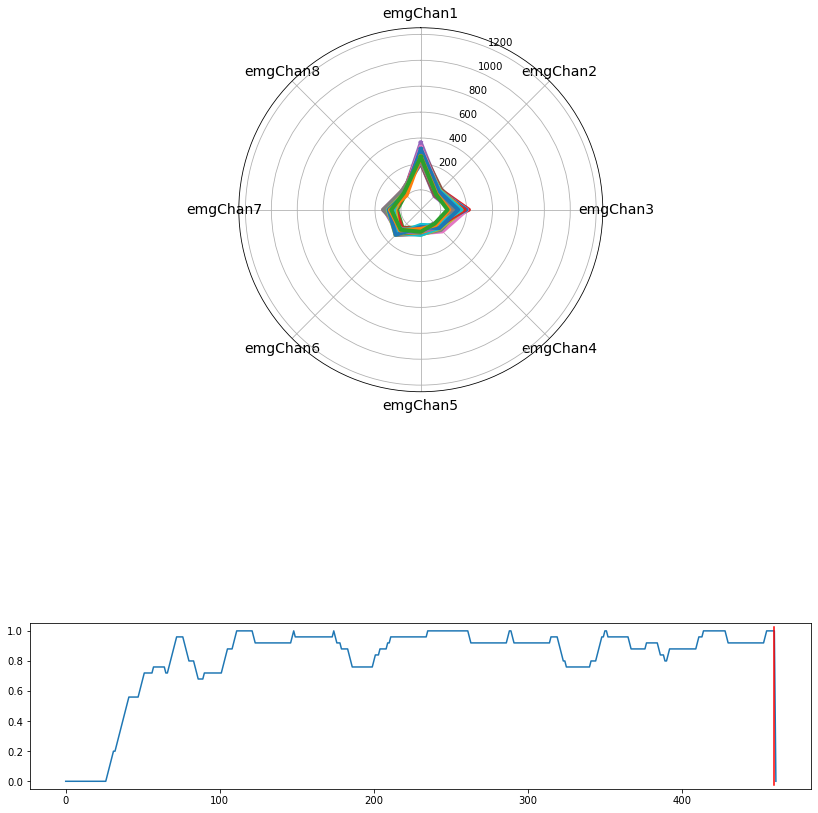

In [29]:
armGame_bi03 = loadTest.training_groups['bio']['sub-bi03']['sess2']['post_trained']
armGame_bi05 = loadTest.training_groups['bio']['sub-bi05']['sess2']['post_trained']
armGame_ar07 = loadTest.training_groups['arb']['sub-ar07']['sess2']['post_trained']
armGame_ar08 = loadTest.training_groups['arb']['sub-ar08']['sess2']['post_trained']

f1_distance_gif(armGame_ar07,'open',0,'test_f1_gif_maker')

#make_raw_emg_radar_plot(armGame_ar07,'open',0,'test_new_gif_maker')

# armGame_bi03.calc_acc()
# armGame_bi03_df = armGame_bi03.df
# radar1_open_bounds = armGame_bi03.chunk_bounds['open'][0]


# armGame_bi05.calc_acc()
# armGame_bi05_df = armGame_bi05.df
# radar2_open_bounds = armGame_bi05.chunk_bounds['open'][0]

# plt_mkr.radar_gif(armGame_bi03_df,radar1_open_bounds, 'bi03_sess2_post_open')
# plt_mkr.radar_gif(armGame_bi05_df,radar2_open_bounds, 'bi05_sess2_post_open')

In [ ]:


armGame_ar07.calc_acc()
armGame_ar08.calc_acc()

armGame_ar07_df = armGame_ar07.df
radar1_open_bounds = armGame_ar07.chunk_bounds['open'][0]

armGame_ar08_df = armGame_ar08.df
radar2_open_bounds = armGame_ar08.chunk_bounds['open'][0]

radar_gif(armGame_ar07_df,radar1_open_bounds, 'ar07_sess2_post_open')
#radar_gif(armGame_ar08_df,radar2_open_bounds, 'ar08_sess2_post_open')

In [ ]:
armGame_ar06 = loadTest.training_groups['arb']['sub-ar06']['sess2']['pre_trained']

armGame_ar06.calc_acc()
armGame_ar06_df = armGame_ar06.df
ar06_open_bounds = armGame_ar06.chunk_bounds['open'][0]

radar_gif(armGame_ar06_df,ar06_open_bounds, 'ar06_sess2_pre_open')

In [ ]:
# def reorganize_df(df):
#     new_df = pd.DataFrame(columns=['SUBJ','GROUP','SESSION','CM_VAL','DATA'])
#     for val in [1,2,3,4,5,6,7,8,9]:
#         val_string = 'VAL' + str(val)
#         temp_df = df[['SUBJ','GROUP','SESSION']]
#         temp_df['CM_VAL'] = val
#         temp_df['DATA'] = df[val_string]

#         new_df = pd.concat([new_df,temp_df])

#     return new_df

# reorganized_df = reorganize_df(classAccData)

# sess2_df = reorganized_df.loc[reorganized_df['SESSION'] == 2]

# sn.violinplot(data=reorganized_df, x='CM_VAL', y='DATA', hue='GROUP')
# sn.stripplot(data=reorganized_df, x='CM_VAL', y='DATA', hue='GROUP')

# g = sn.FacetGrid(reorganized_df, col = 'CM_VAL', height=6,aspect=.8,col_wrap=3)
# g.map(sn.violinplot, 'GROUP', 'DATA')
# g.map(sn.stripplot, 'GROUP', 'DATA', color='yellow')

In [ ]:
# sess2_df = reorganized_df.loc[reorganized_df['SESSION'] == 'sess2']

# sess5_df = reorganized_df.loc[reorganized_df['SESSION'] == 'sess5']

# sess6_df = reorganized_df.loc[reorganized_df['SESSION'] == 'sess6']

# sn.violinplot(data=sess2_df, x='CM_VAL', y='DATA', hue='GROUP')
# sn.stripplot(data=sess2_df, x='CM_VAL', y='DATA', hue='GROUP')

# sess2_g = sn.FacetGrid(sess2_df, col = 'CM_VAL', height=6,aspect=.8,col_wrap=3)
# sess2_g.map(sn.violinplot, 'GROUP', 'DATA')
# sess2_g.map(sn.stripplot, 'GROUP', 'DATA', color='yellow')

# sn.violinplot(data=sess5_df, x='CM_VAL', y='DATA', hue='GROUP')
# sn.stripplot(data=sess5_df, x='CM_VAL', y='DATA', hue='GROUP')

# sess5_g = sn.FacetGrid(sess5_df, col = 'CM_VAL', height=6,aspect=.8,col_wrap=3)
# sess5_g.map(sn.violinplot, 'GROUP', 'DATA')
# sess5_g.map(sn.stripplot, 'GROUP', 'DATA', color='yellow')

# sn.violinplot(data=sess6_df, x='CM_VAL', y='DATA', hue='GROUP')
# sn.stripplot(data=sess6_df, x='CM_VAL', y='DATA', hue='GROUP')

# sess6_g = sn.FacetGrid(sess6_df, col = 'CM_VAL', height=6,aspect=.8,col_wrap=3)
# sess6_g.map(sn.violinplot, 'GROUP', 'DATA')
# sess6_g.map(sn.stripplot, 'GROUP', 'DATA', color='yellow')